In [ ]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import (
    layers,
    models,
    callbacks,
    utils,
    metrics,
    losses,
    optimizers,
)

from scipy.stats import norm
import pandas as pd

In [ ]:
IMAGE_SIZE = 64
CHANNELS = 3
BATCH_SIZE = 128
NUM_FEATURES = 64
Z_DIM = 200
LEARNING_RATE = 0.0005
EPOCHS = 10
BETA = 2000
LOAD_MODEL = False

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"jayshah1234","key":"b5a70f58d9814ed536fb83b549b26d2c"}'}

In [ ]:
# Move the uploaded kaggle.json file to the correct location
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Now you can use the Kaggle API to download the dataset
kaggle_username = "jessicali9530"
dataset_name = "celeba-dataset"

# Create the Kaggle dataset URL
dataset_url = f"{kaggle_username}/{dataset_name}"

# Download the dataset using Kaggle API
!kaggle datasets download -d $dataset_url

# Unzip the downloaded dataset
!unzip -q {dataset_name}.zip -d {dataset_name}

100% 1.33G/1.33G [00:37<00:00, 37.1MB/s]
100% 1.33G/1.33G [00:37<00:00, 38.2MB/s]


In [ ]:
train_data = utils.image_dataset_from_directory(
 "/content/celeba-dataset/img_align_celeba/img_align_celeba",
 labels=None,
 color_mode="rgb",
 image_size=(64, 64),
 batch_size=128,
 shuffle=True,
 seed=42,
 interpolation="bilinear",
)

Found 202599 files belonging to 1 classes.


In [ ]:
def preprocess(img):
 img = tf.cast(img, "float32") / 255.0
 return img
train = train_data.map(lambda x: preprocess(x))

The network architecture for the faces model is similar to the Fashion-MNIST exam‐
ple, with a few slight differences:

• Our data now has three input channels (RGB) instead of one (grayscale). This
means we need to change the number of channels in the final convolutional
transpose layer of the decoder to 3.

• We shall be using a latent space with 200 dimensions instead of 2. Since faces are
much more complex than the Fashion-MNIST images, we increase the dimen‐
sionality of the latent space so that the network can encode a satisfactory amount
of detail from the images.

• There are batch normalization layers after each convolutional layer to stabilize
training. Even though each batch takes a longer time to run, the number of
batches required to reach the same loss is greatly reduced.

• We increase the β factor for the KL divergence to 2,000. This is a parameter that
requires tuning; for this dataset and architecture this value was found to generate
good results.


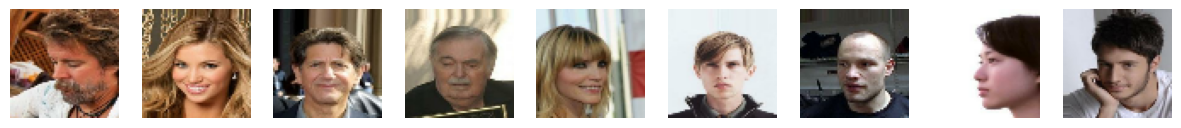

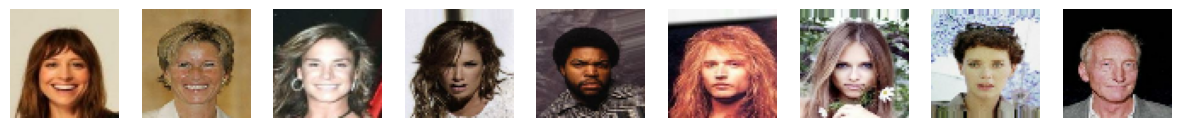

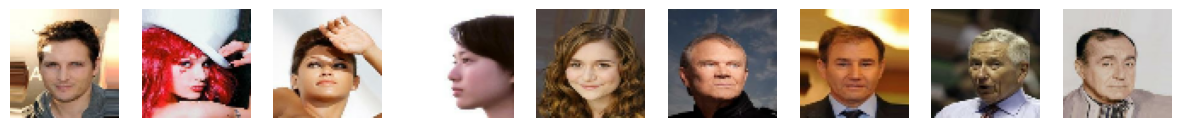

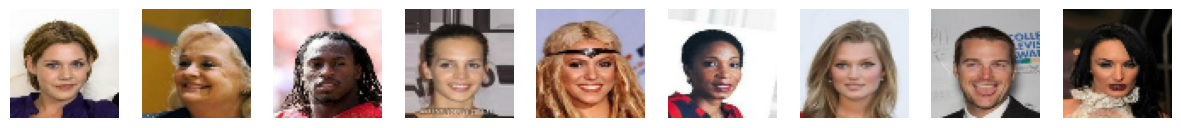

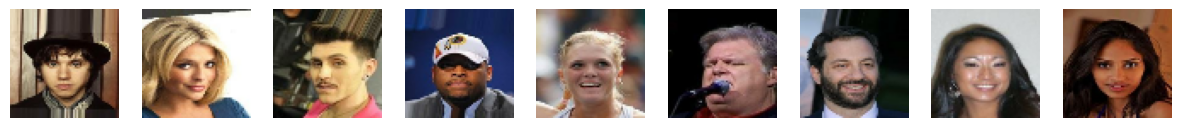

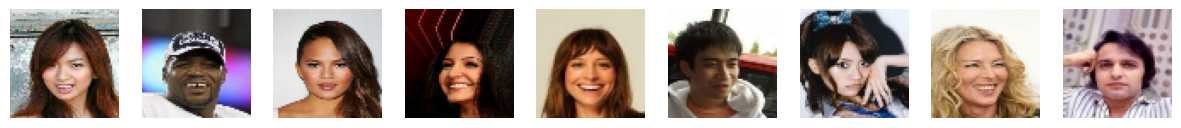

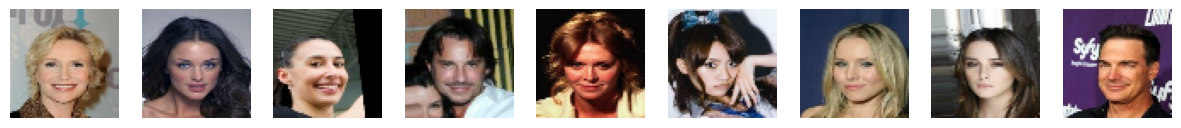

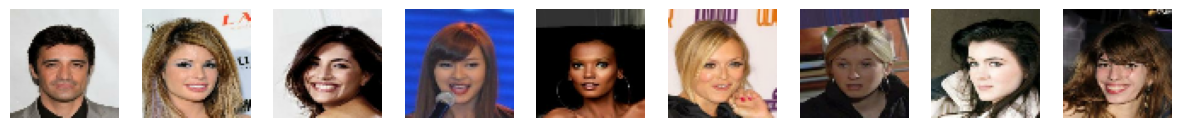

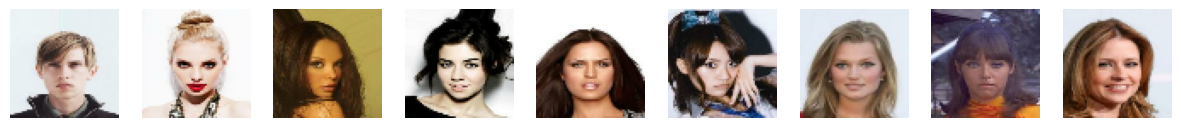

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'train' dataset is already defined

# Function to display images
def display_images(images, cmap=None):
    plt.figure(figsize=(15, 15))
    for j in range(9):
        celeb_img = images[j].numpy()
        celeb_img = np.array(celeb_img * 255, dtype=np.uint8)  # Convert back to uint8 for display
        plt.subplot(990 + 1 + j)
        plt.imshow(celeb_img, cmap=cmap)
        plt.axis('off')
    plt.show()

# Display random images from the 'train' dataset
for k in range(9):
    train_sample = next(iter(train.take(1)))
    display_images(train_sample, cmap=None)


In [ ]:
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = K.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [ ]:
# Encoder
encoder_input = layers.Input(
    shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS), name="encoder_input"
)
x = layers.Conv2D(NUM_FEATURES, kernel_size=3, strides=2, padding="same")(
    encoder_input
)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(NUM_FEATURES, kernel_size=3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(NUM_FEATURES, kernel_size=3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(NUM_FEATURES, kernel_size=3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(NUM_FEATURES, kernel_size=3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
shape_before_flattening = K.int_shape(x)[1:]  # the decoder will need this!

x = layers.Flatten()(x)
z_mean = layers.Dense(Z_DIM, name="z_mean")(x)
z_log_var = layers.Dense(Z_DIM, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])

encoder = models.Model(encoder_input, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 32, 32, 64)           1792      ['encoder_input[0][0]']       
                                                                                                  
 batch_normalization (Batch  (None, 32, 32, 64)           256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 64)           0         ['batch_normalization[0]

In [ ]:
# Decoder
decoder_input = layers.Input(shape=(Z_DIM,), name="decoder_input")
x = layers.Dense(np.prod(shape_before_flattening))(decoder_input)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Reshape(shape_before_flattening)(x)
x = layers.Conv2DTranspose(
    NUM_FEATURES, kernel_size=3, strides=2, padding="same"
)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2DTranspose(
    NUM_FEATURES, kernel_size=3, strides=2, padding="same"
)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2DTranspose(
    NUM_FEATURES, kernel_size=3, strides=2, padding="same"
)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2DTranspose(
    NUM_FEATURES, kernel_size=3, strides=2, padding="same"
)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2DTranspose(
    NUM_FEATURES, kernel_size=3, strides=2, padding="same"
)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
decoder_output = layers.Conv2DTranspose(
    CHANNELS, kernel_size=3, strides=1, activation="sigmoid", padding="same"
)(x)
decoder = models.Model(decoder_input, decoder_output)
decoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 200)]             0         
                                                                 
 dense (Dense)               (None, 256)               51456     
                                                                 
 batch_normalization_5 (Bat  (None, 256)               1024      
 chNormalization)                                                
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 256)               0         
                                                                 
 reshape (Reshape)           (None, 2, 2, 64)          0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 4, 4, 64)          36928     
 anspose)                                                    

In [ ]:
class VAE(models.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def call(self, inputs):
        """Call the model on a particular input."""
        z_mean, z_log_var, z = encoder(inputs)
        reconstruction = decoder(z)
        return z_mean, z_log_var, reconstruction

    def train_step(self, data):
        """Step run during training."""
        with tf.GradientTape() as tape:
            z_mean, z_log_var, reconstruction = self(data, training=True)
            reconstruction_loss = tf.reduce_mean(
                BETA * losses.mean_squared_error(data, reconstruction)
            )
            kl_loss = tf.reduce_mean(
                tf.reduce_sum(
                    -0.5
                    * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
                    axis=1,
                )
            )
            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    def test_step(self, data):
        """Step run during validation."""
        if isinstance(data, tuple):
            data = data[0]

        z_mean, z_log_var, reconstruction = self(data)
        reconstruction_loss = tf.reduce_mean(
            BETA * losses.mean_squared_error(data, reconstruction)
        )
        kl_loss = tf.reduce_mean(
            tf.reduce_sum(
                -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
                axis=1,
            )
        )
        total_loss = reconstruction_loss + kl_loss

        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

In [ ]:
# Create a variational autoencoder
vae = VAE(encoder, decoder)

In [ ]:
# Compile the variational autoencoder
optimizer = optimizers.Adam(learning_rate=LEARNING_RATE)
vae.compile(optimizer=optimizer)

In [ ]:
# Create a model save checkpoint
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath="./checkpoint",
    save_weights_only=False,
    save_freq="epoch",
    monitor="loss",
    mode="min",
    save_best_only=True,
    verbose=0,
)

tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")


class ImageGenerator(callbacks.Callback):
    def __init__(self, num_img, latent_dim):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(
            shape=(self.num_img, self.latent_dim)
        )
        generated_images = self.model.decoder(random_latent_vectors)
        generated_images *= 255
        generated_images = generated_images.numpy()

        for i in range(self.num_img):
            img = utils.array_to_img(generated_images[i])
            plt.imshow(img)
            plt.axis('off')

            plt.show()



Epoch 1/10
1583/1583 [==============================] - ETA: 0s - loss: 103.0401 - reconstruction_loss: 69.2936 - kl_loss: 14.8336

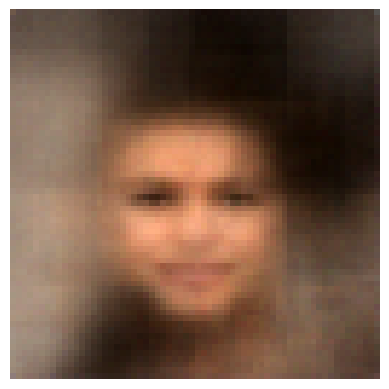

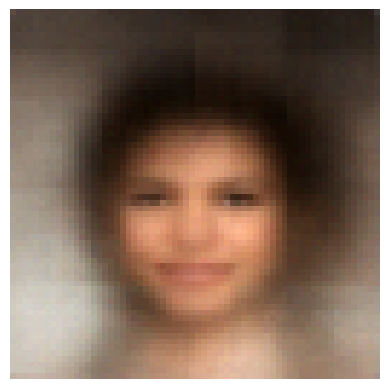

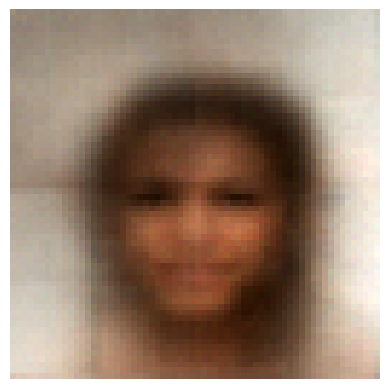

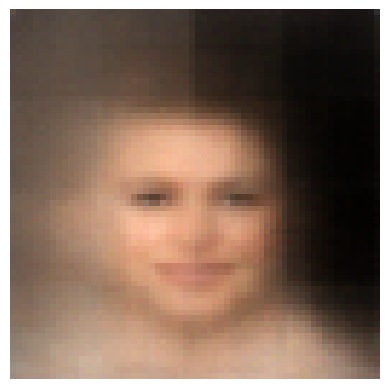

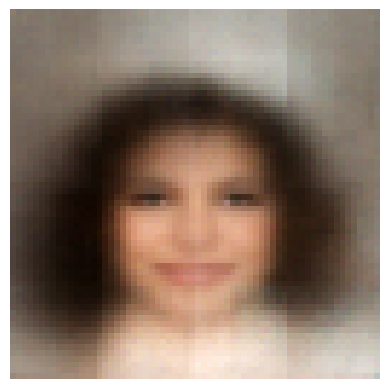

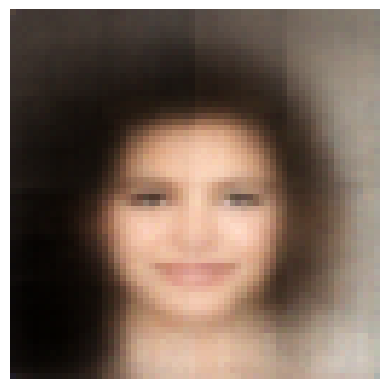

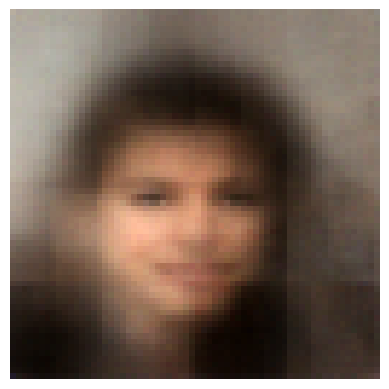

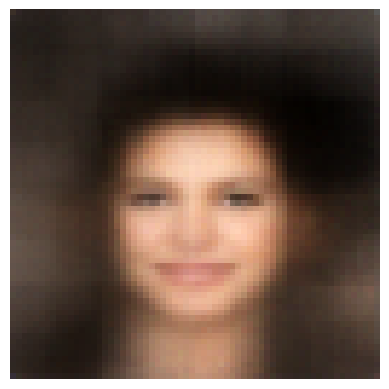

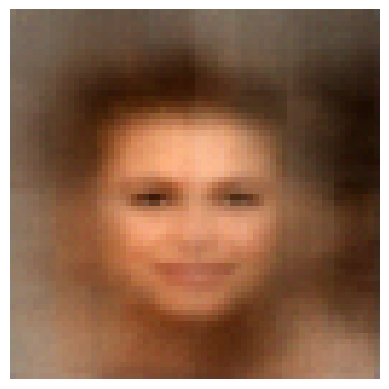

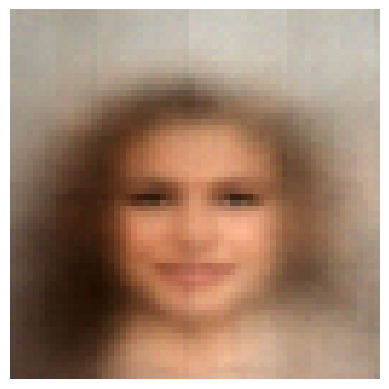

1583/1583 [==============================] - 127s 72ms/step - loss: 103.0282 - reconstruction_loss: 69.2936 - kl_loss: 14.8336
Epoch 2/10
1583/1583 [==============================] - ETA: 0s - loss: 70.9822 - reconstruction_loss: 54.9759 - kl_loss: 14.9814

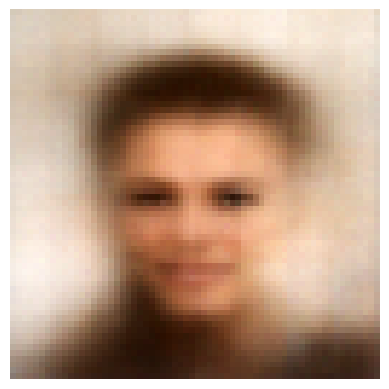

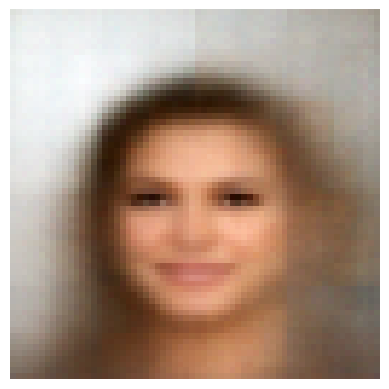

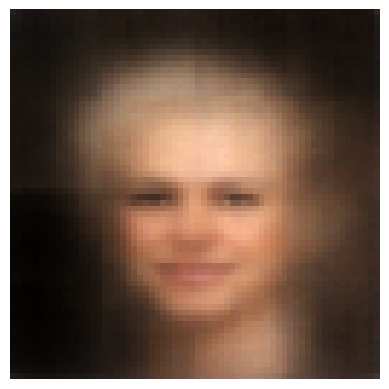

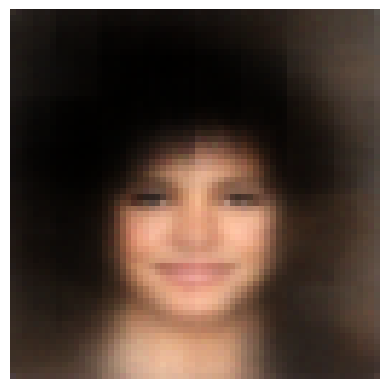

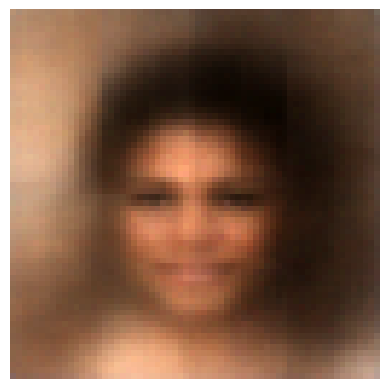

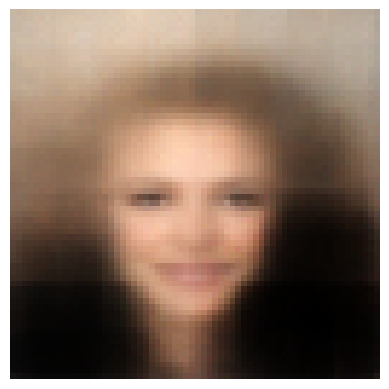

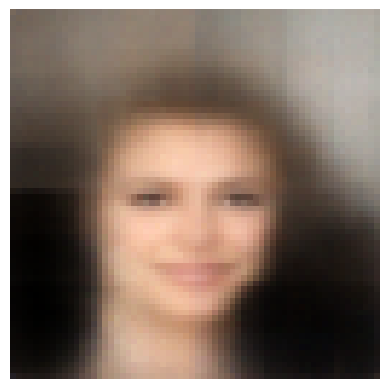

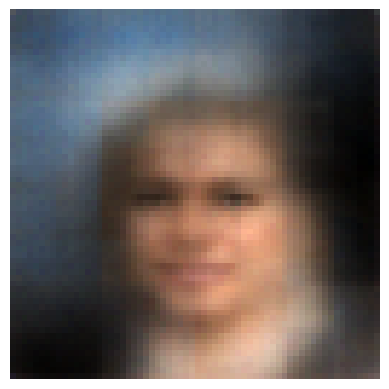

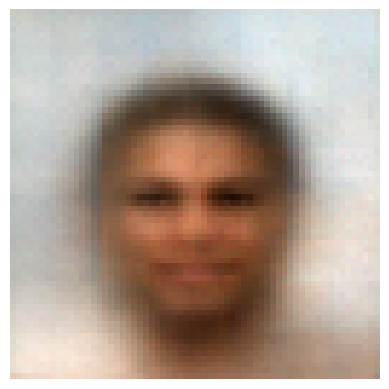

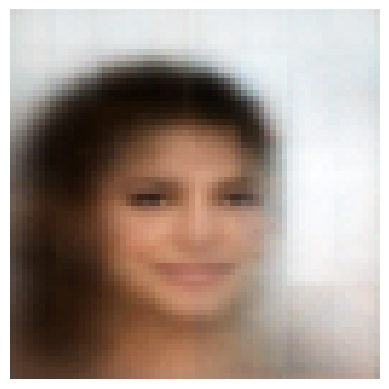

1583/1583 [==============================] - 117s 74ms/step - loss: 70.9816 - reconstruction_loss: 54.9759 - kl_loss: 14.9814
Epoch 3/10
1583/1583 [==============================] - ETA: 0s - loss: 68.1075 - reconstruction_loss: 51.9575 - kl_loss: 15.7102

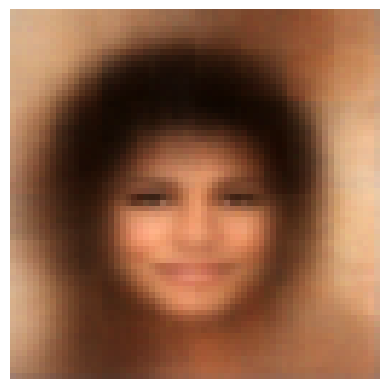

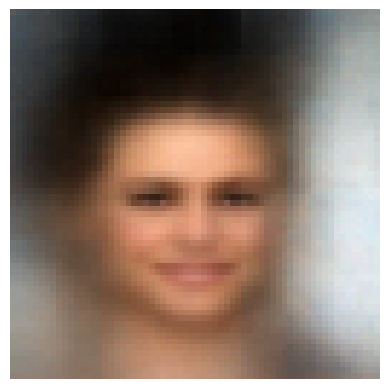

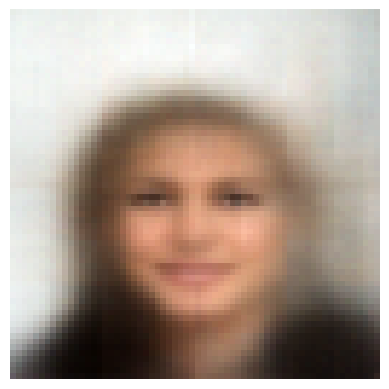

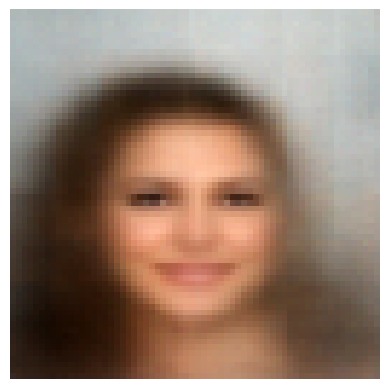

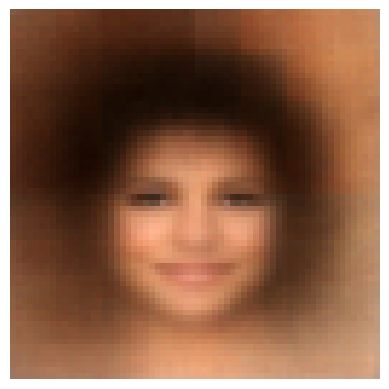

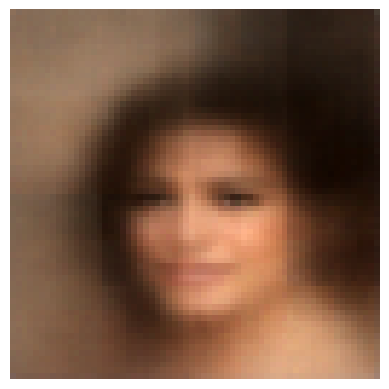

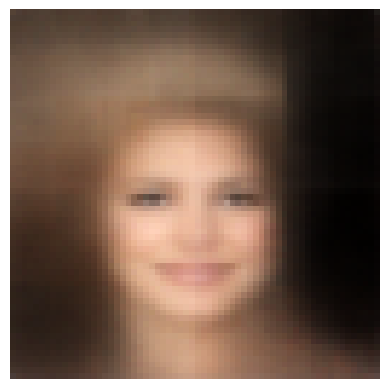

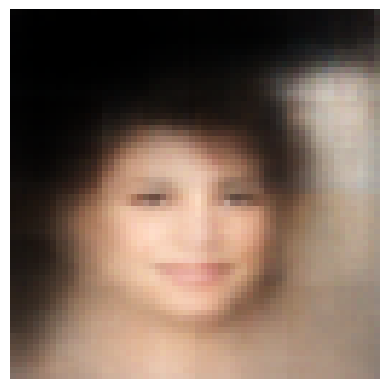

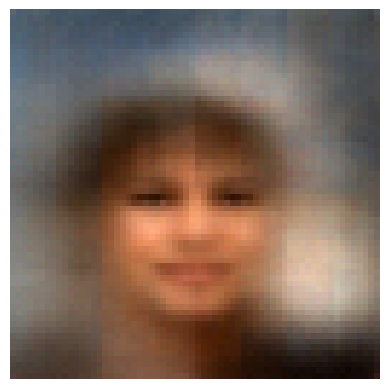

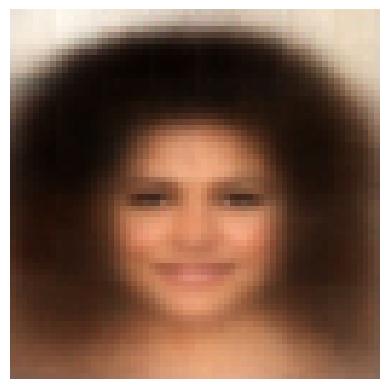

1583/1583 [==============================] - 128s 80ms/step - loss: 68.1072 - reconstruction_loss: 51.9575 - kl_loss: 15.7102
Epoch 4/10
1583/1583 [==============================] - ETA: 0s - loss: 66.8164 - reconstruction_loss: 50.4756 - kl_loss: 16.0654

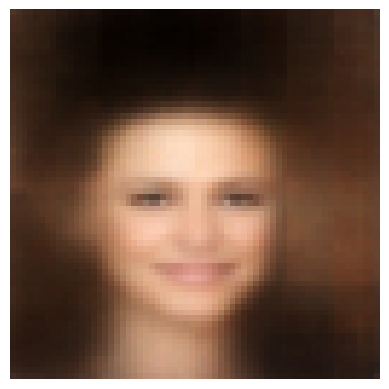

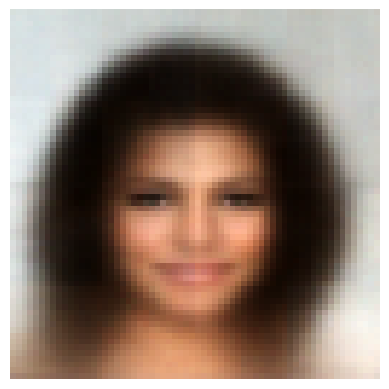

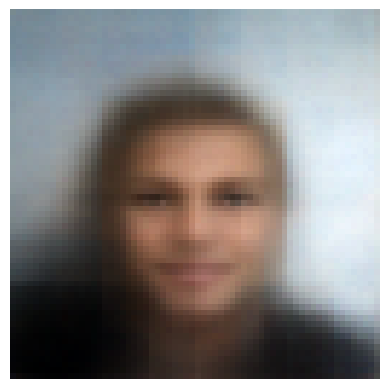

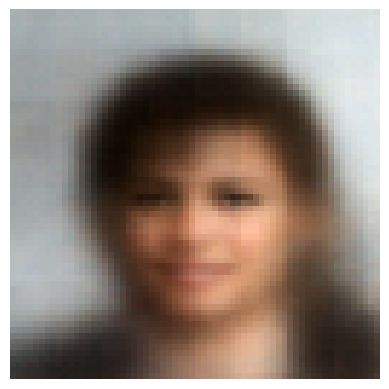

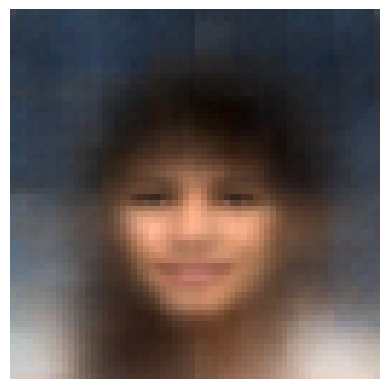

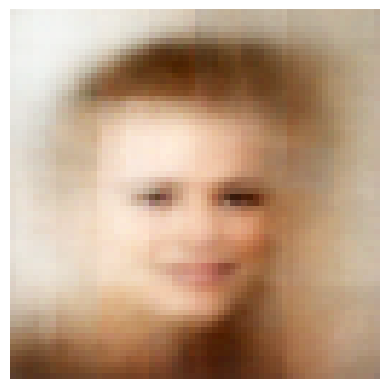

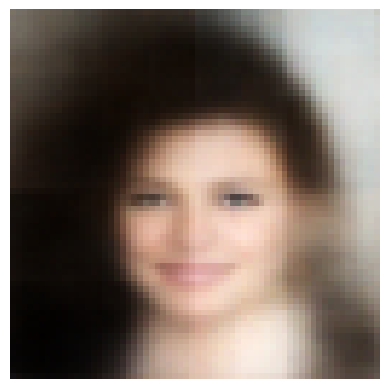

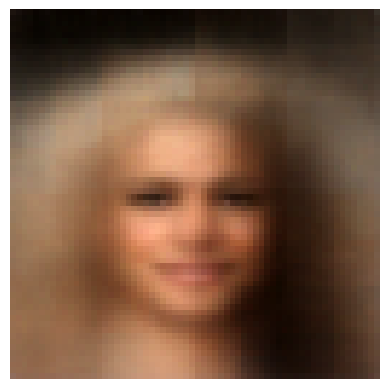

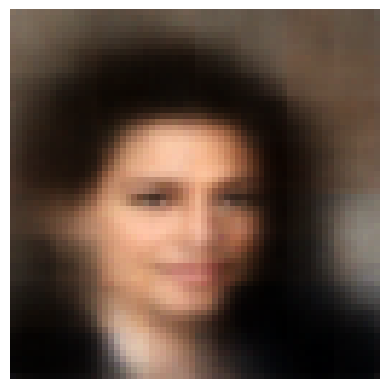

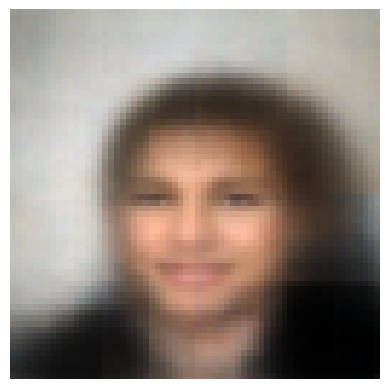

1583/1583 [==============================] - 133s 84ms/step - loss: 66.8162 - reconstruction_loss: 50.4756 - kl_loss: 16.0654
Epoch 5/10
1583/1583 [==============================] - ETA: 0s - loss: 65.8161 - reconstruction_loss: 49.0281 - kl_loss: 16.5098

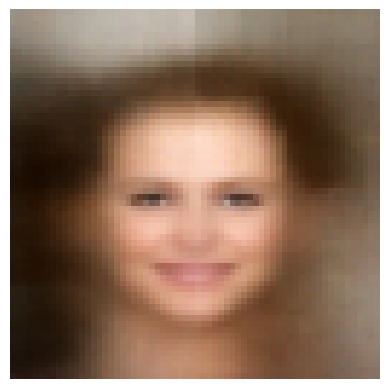

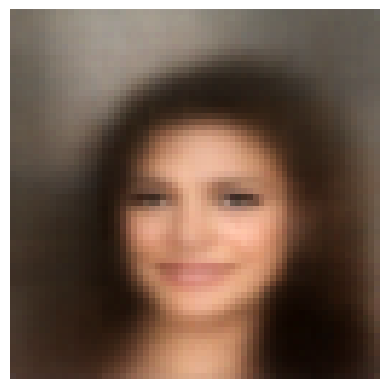

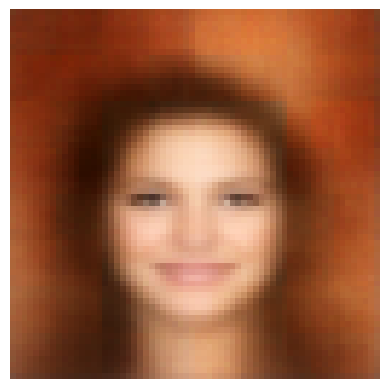

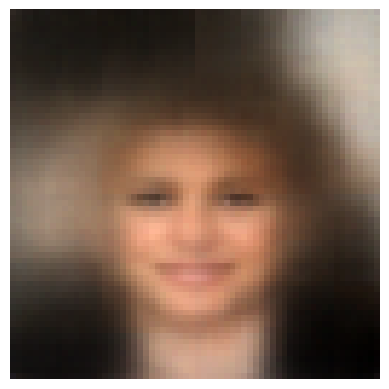

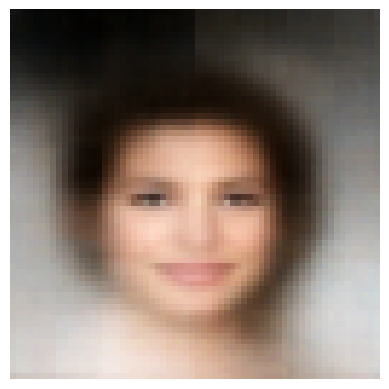

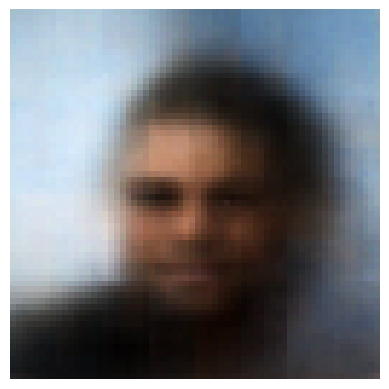

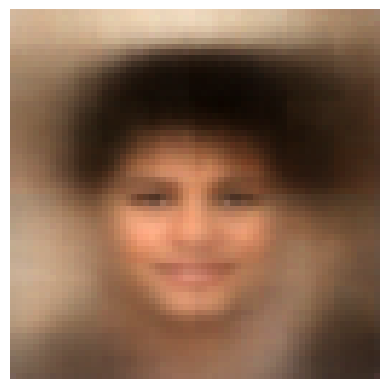

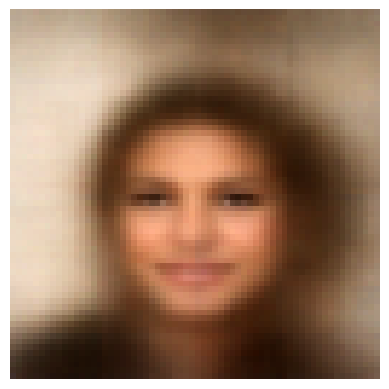

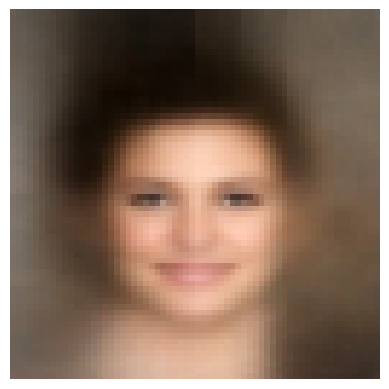

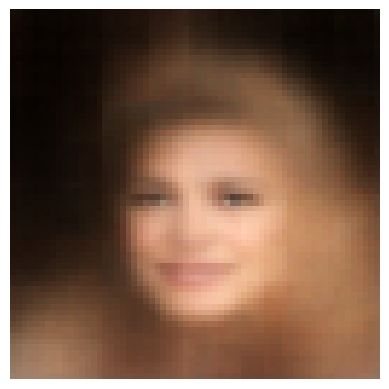

1583/1583 [==============================] - 122s 77ms/step - loss: 65.8160 - reconstruction_loss: 49.0281 - kl_loss: 16.5098
Epoch 6/10
1583/1583 [==============================] - ETA: 0s - loss: 65.1497 - reconstruction_loss: 48.1522 - kl_loss: 16.8138

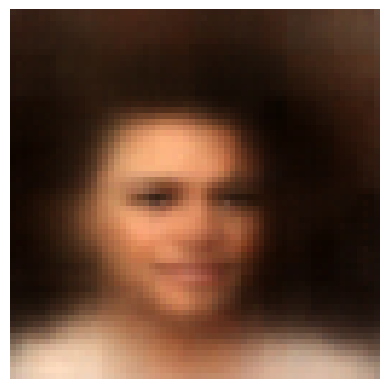

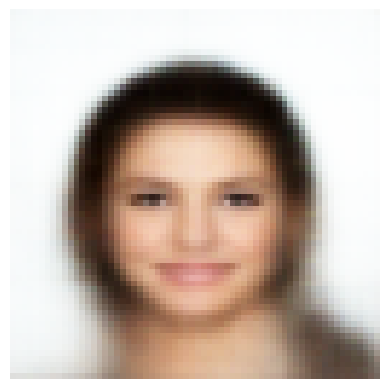

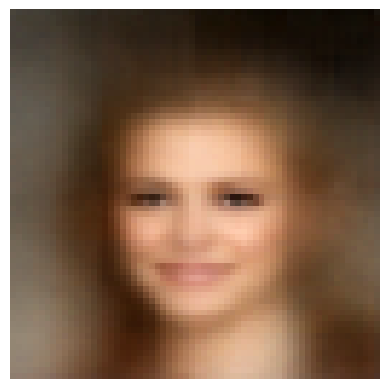

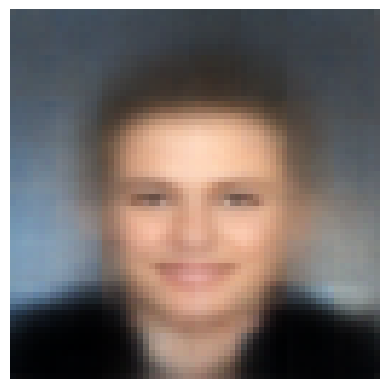

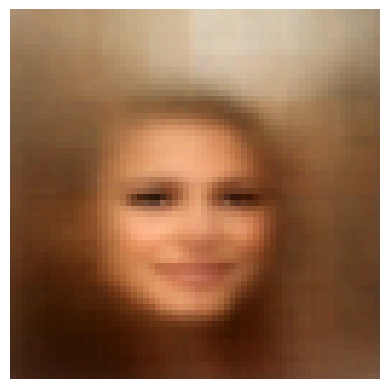

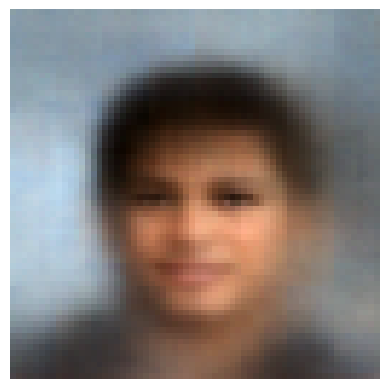

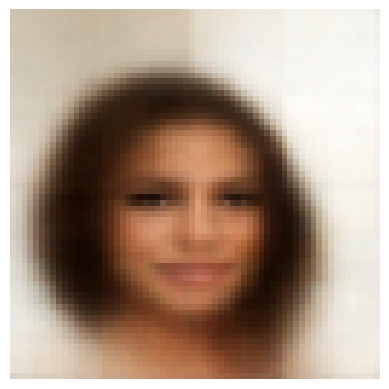

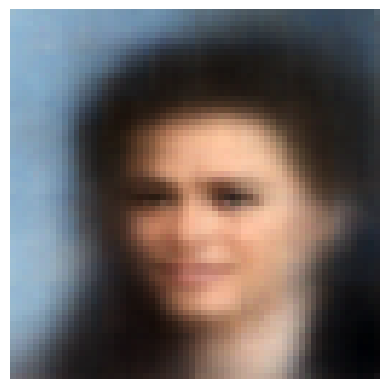

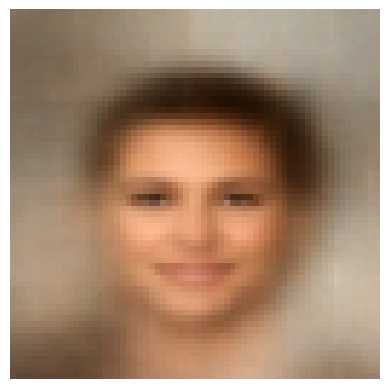

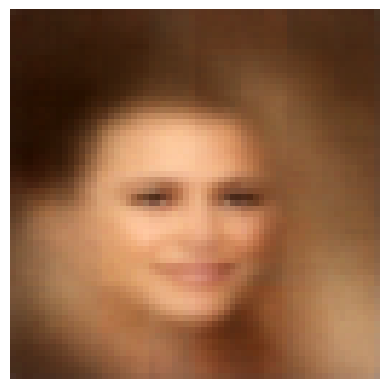

1583/1583 [==============================] - 129s 81ms/step - loss: 65.1496 - reconstruction_loss: 48.1522 - kl_loss: 16.8138
Epoch 7/10
1583/1583 [==============================] - ETA: 0s - loss: 64.8203 - reconstruction_loss: 47.7664 - kl_loss: 16.9378

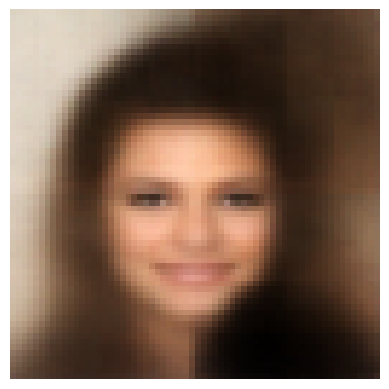

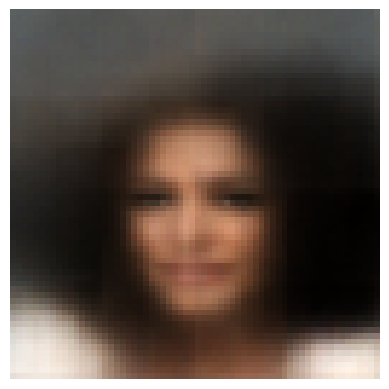

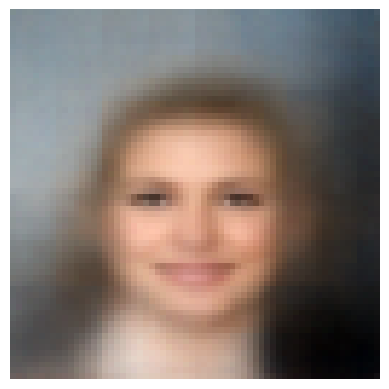

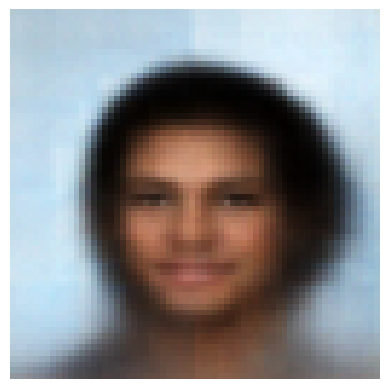

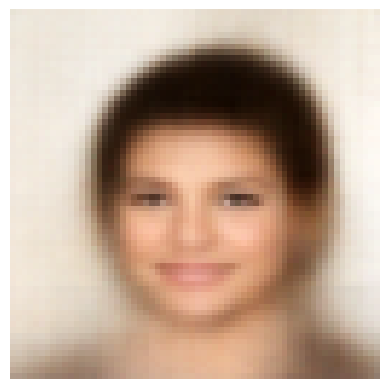

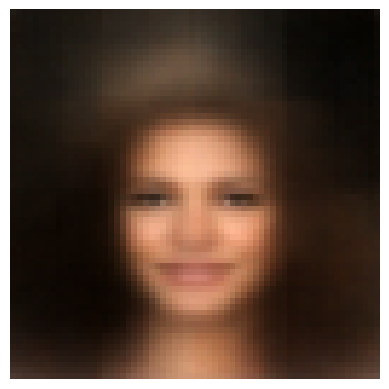

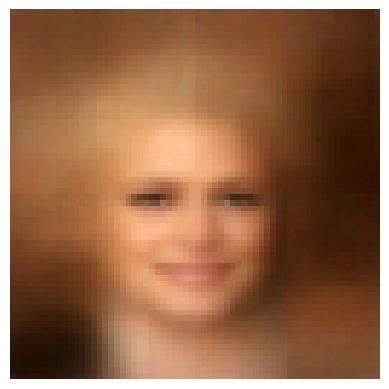

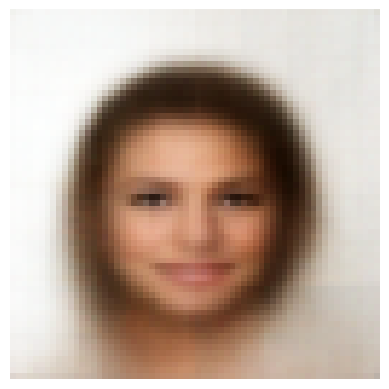

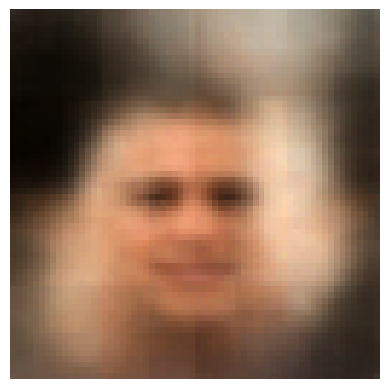

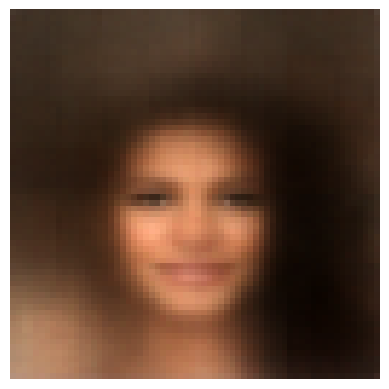

1583/1583 [==============================] - 119s 75ms/step - loss: 64.8203 - reconstruction_loss: 47.7664 - kl_loss: 16.9378
Epoch 8/10
1583/1583 [==============================] - ETA: 0s - loss: 64.5658 - reconstruction_loss: 47.4716 - kl_loss: 17.0036

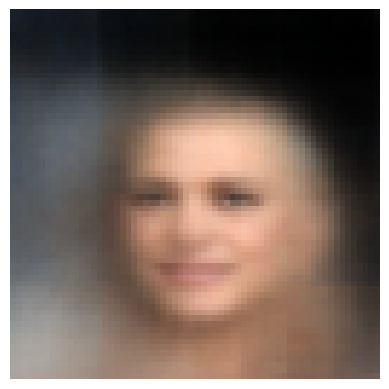

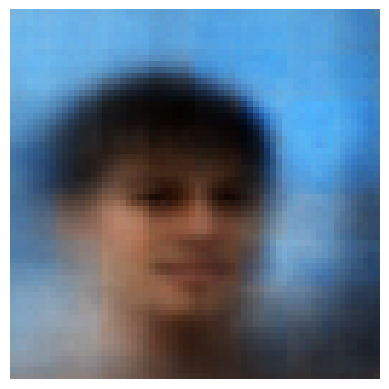

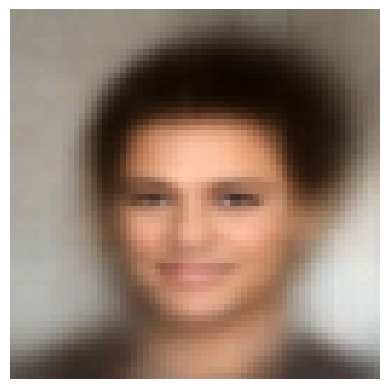

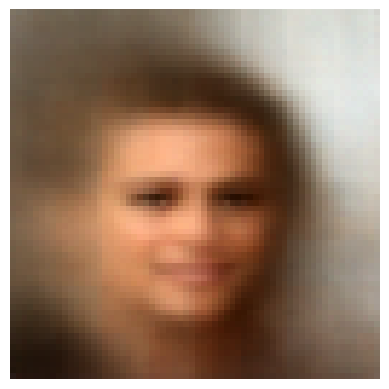

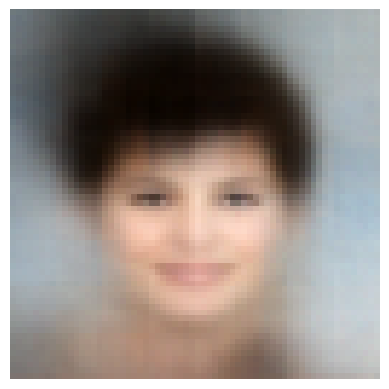

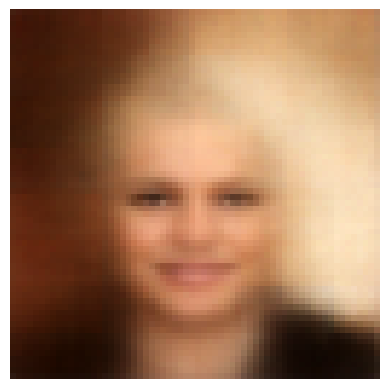

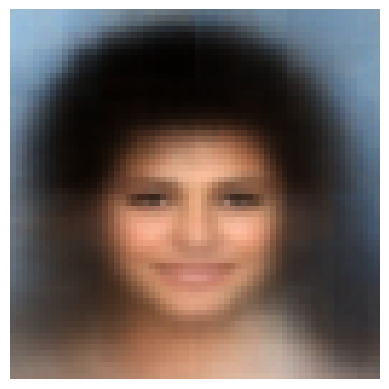

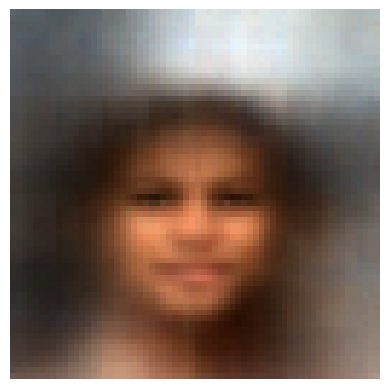

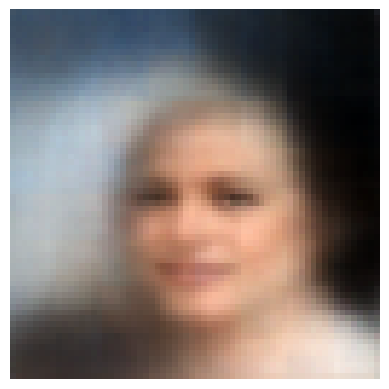

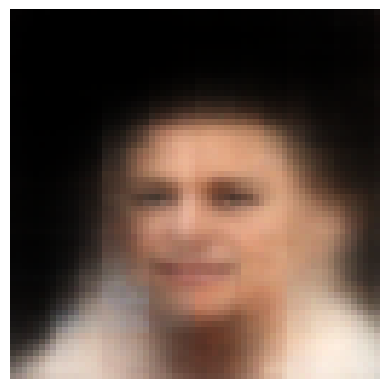

1583/1583 [==============================] - 120s 76ms/step - loss: 64.5657 - reconstruction_loss: 47.4716 - kl_loss: 17.0036
Epoch 9/10
1583/1583 [==============================] - ETA: 0s - loss: 64.3922 - reconstruction_loss: 47.2472 - kl_loss: 17.0623

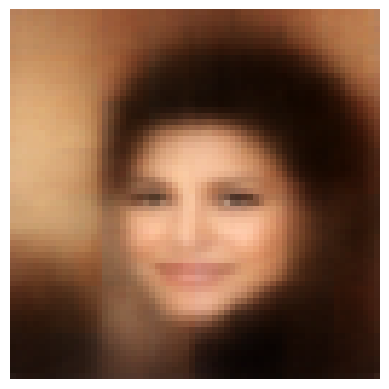

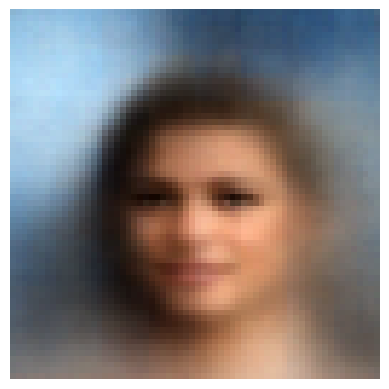

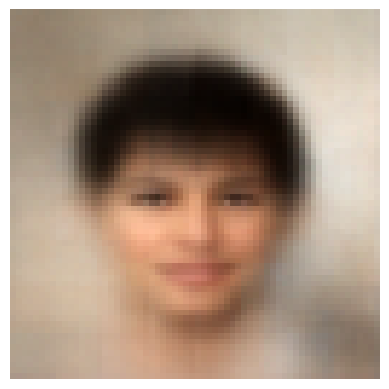

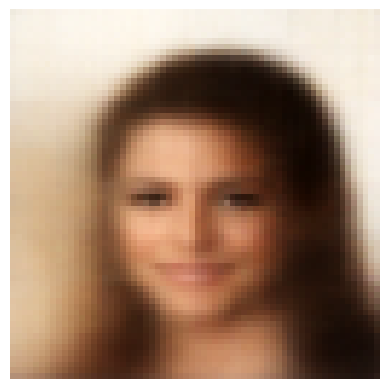

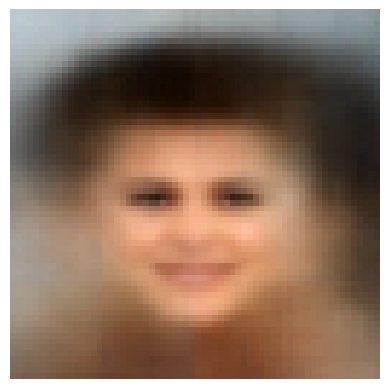

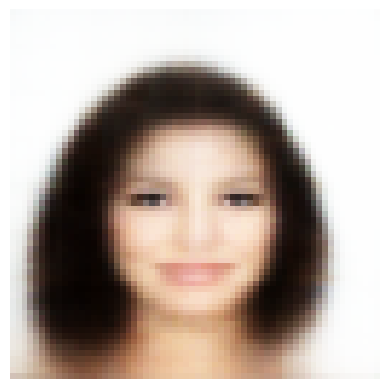

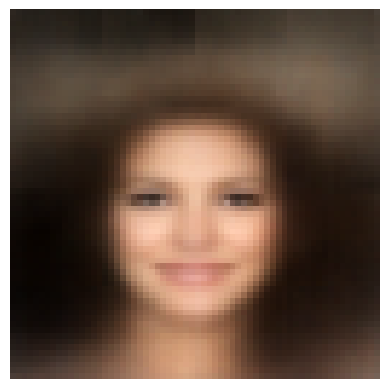

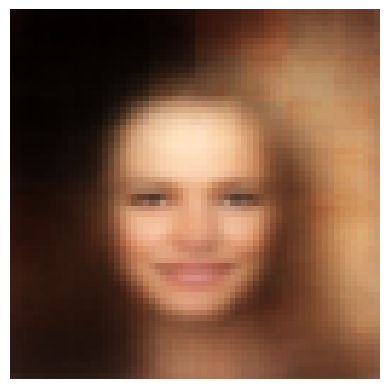

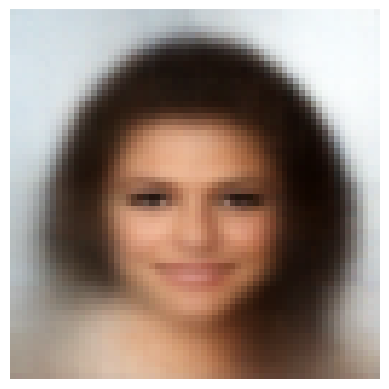

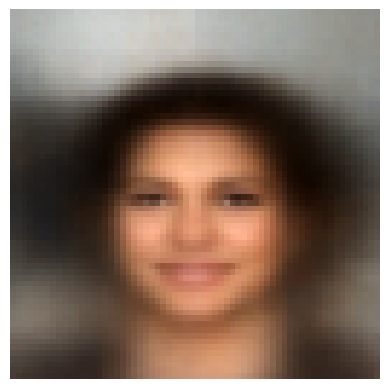

1583/1583 [==============================] - 123s 78ms/step - loss: 64.3921 - reconstruction_loss: 47.2472 - kl_loss: 17.0623
Epoch 10/10
1583/1583 [==============================] - ETA: 0s - loss: 64.2274 - reconstruction_loss: 47.0421 - kl_loss: 17.1154

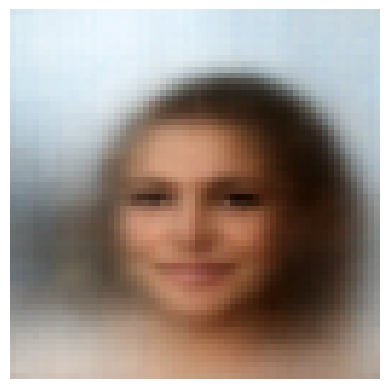

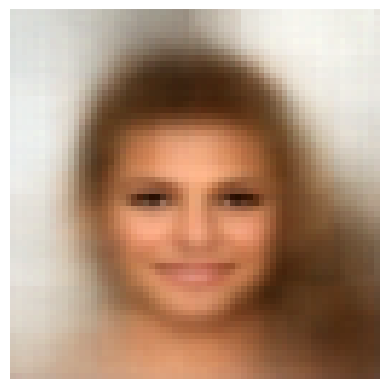

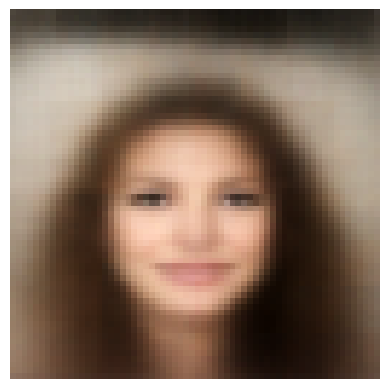

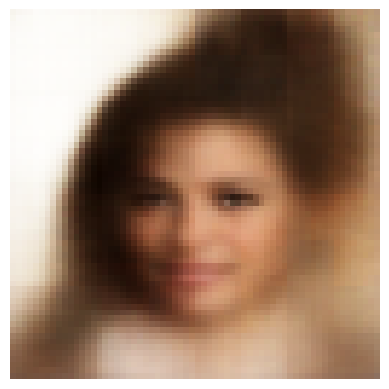

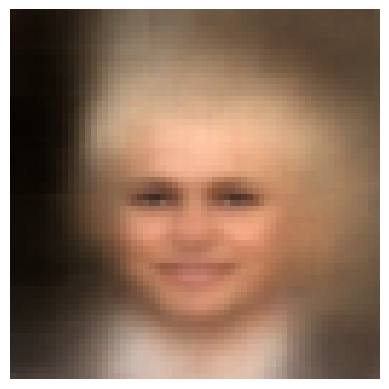

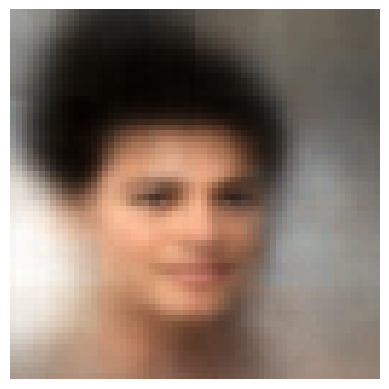

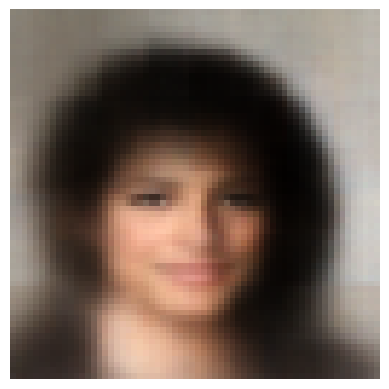

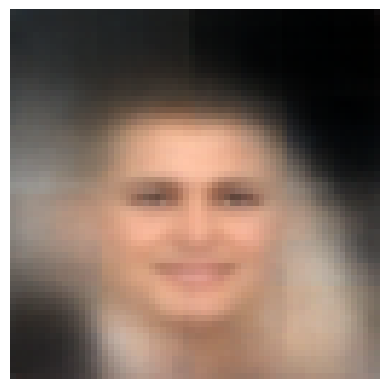

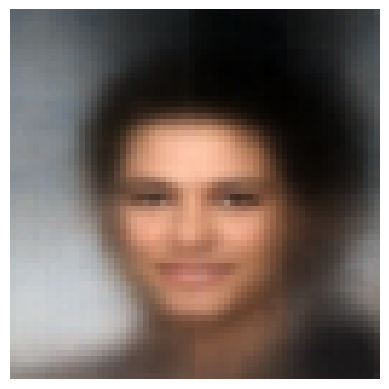

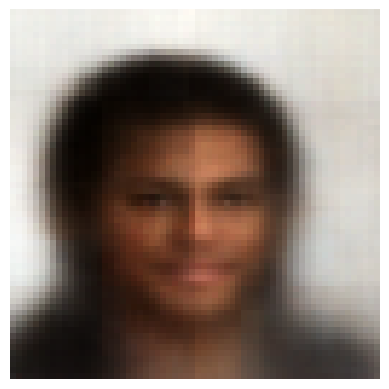

1583/1583 [==============================] - 124s 78ms/step - loss: 64.2274 - reconstruction_loss: 47.0421 - kl_loss: 17.1154


In [ ]:
vae.fit(
    train,
    epochs=EPOCHS,
    callbacks=[
        model_checkpoint_callback,
        ImageGenerator(num_img=10, latent_dim=Z_DIM),
    ],
)

In [ ]:
# Select a subset of the test set
batches_to_predict = 1
example_images = np.array(
    list(train.take(batches_to_predict).get_single_element())
)

4/4 [==============================] - 1s 7ms/step
Example real clothing items


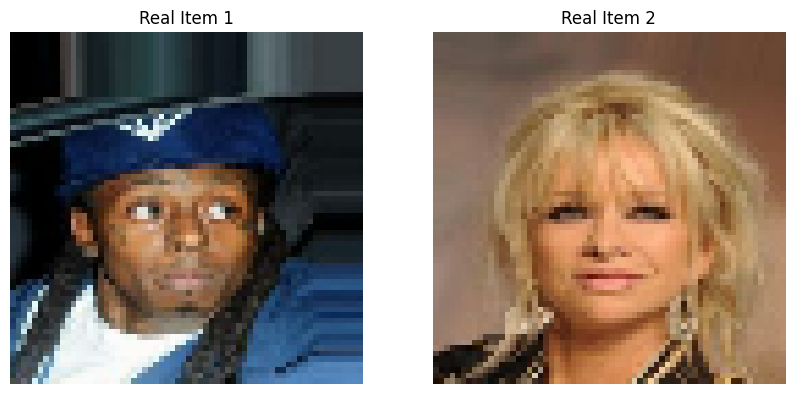

Reconstructions


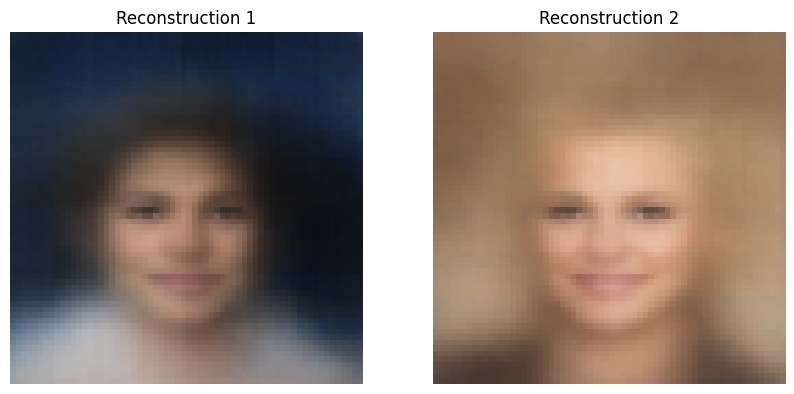

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Create autoencoder predictions
z_mean, z_log_var, reconstructions = vae.predict(example_images)

# Display example real clothing items
print("Example real clothing items")
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

for i, ax in enumerate(axes):
    ax.imshow(example_images[i].reshape(64, 64, 3))  # Change reshape dimensions
    ax.axis('off')
    ax.set_title(f'Real Item {i + 1}')

plt.show()

# Display reconstructions
print("Reconstructions")
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

for i, ax in enumerate(axes):
    ax.imshow(reconstructions[i].reshape(64, 64, 3))  # Change reshape dimensions
    ax.axis('off')
    ax.set_title(f'Reconstruction {i + 1}')

plt.show()


We can see that the VAE has successfully captured the key features of each face—the
angle of the head, the hairstyle, the expression, etc. Some of the fine detail is missing,
but it is important to remember that the aim of building variational autoencoders
isn’t to achieve perfect reconstruction loss. Our end goal is to sample from the latent
space in order to generate new faces.


For this to be possible we must check that the distribution of points in the latent
space approximately resembles a multivariate standard normal distribution. If we see
any dimensions that are significantly different from a standard normal distribution, we should probably reduce the reconstruction loss factor, since the KL divergence
term isn’t having enough effect.

# Latent space distribution

The first 50 dimensions in our latent space are shown in Figure. There aren’t any
distributions that stand out as being significantly different from the standard normal,
so we can move on to generating some faces!

4/4 [==============================] - 0s 5ms/step


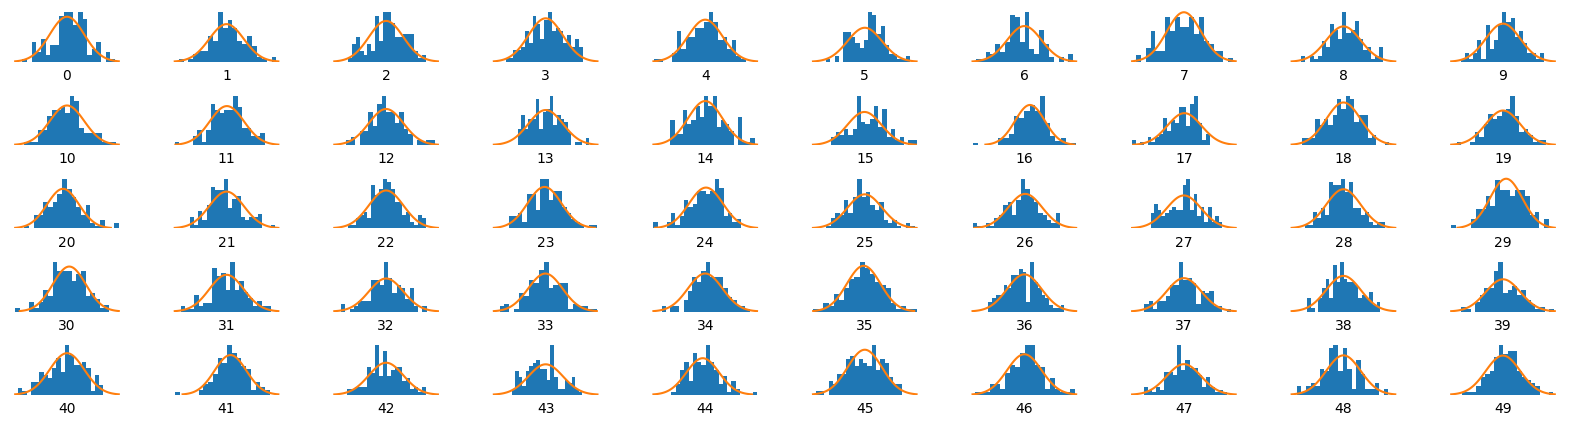

In [ ]:
_, _, z = vae.encoder.predict(example_images)

x = np.linspace(-3, 3, 100)

fig = plt.figure(figsize=(20, 5))
fig.subplots_adjust(hspace=0.6, wspace=0.4)

for i in range(50):
    ax = fig.add_subplot(5, 10, i + 1)
    ax.hist(z[:, i], density=True, bins=20)
    ax.axis("off")
    ax.text(
        0.5, -0.35, str(i), fontsize=10, ha="center", transform=ax.transAxes
    )
    ax.plot(x, norm.pdf(x))

plt.show()

# Generate New Faces

In [ ]:
# Sample some points in the latent space, from the standard normal distribution
grid_width, grid_height = (10, 3)
z_sample = np.random.normal(size=(grid_width * grid_height, Z_DIM))

In [ ]:
# Decode the sampled points
reconstructions = decoder.predict(z_sample)

1/1 [==============================] - 1s 608ms/step


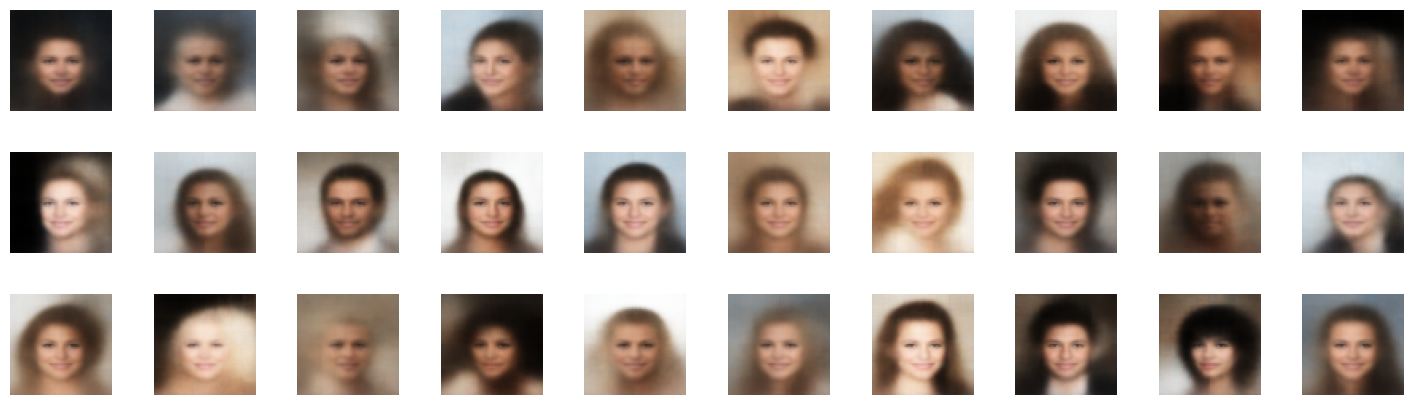

In [ ]:
# Draw a plot of decoded images
fig = plt.figure(figsize=(18, 5))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

# Output the grid of faces
for i in range(grid_width * grid_height):
    ax = fig.add_subplot(grid_height, grid_width, i + 1)
    ax.axis("off")
    ax.imshow(reconstructions[i, :, :])

Amazingly, the VAE is able to take the set of points that we sampled from a standard
normal distribution and convert each into a convincing image of a person’s face. This
is our first glimpse of the true power of generative models!

# Latent Space Arithmetic

One benefit of mapping images into a lower-dimensional latent space is that we can
perform arithmetic on vectors in this latent space that has a visual analogue when
decoded back into the original image domain.

 Each image in the CelebA dataset is labeled with
attributes, one of which is Smiling. If we take the average position of encoded images
in the latent space with the attribute Smiling and subtract the average position of
encoded images that do not have the attribute Smiling, we will obtain the vector that
points in the direction of Smiling, which is exactly what we need.


Conceptually, we are performing the following vector arithmetic in the latent space,
where alpha is a factor that determines how much of the feature vector is added or
subtracted:


z_new = z + alpha * feature_vector (Similing vector)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


def get_vector_from_label(data, vae, embedding_dim, label):
    current_sum_POS = np.zeros(shape=embedding_dim, dtype="float32")
    current_n_POS = 0
    current_mean_POS = np.zeros(shape=embedding_dim, dtype="float32")

    current_sum_NEG = np.zeros(shape=embedding_dim, dtype="float32")
    current_n_NEG = 0
    current_mean_NEG = np.zeros(shape=embedding_dim, dtype="float32")

    current_vector = np.zeros(shape=embedding_dim, dtype="float32")
    current_dist = 0

    print("label: " + label)
    print("images : POS move : NEG move :distance : 𝛥 distance")
    while current_n_POS < 10000:
        batch = list(data.take(1).get_single_element())
        im = batch[0]
        attribute = batch[1]

        _, _, z = vae.encoder.predict(np.array(im), verbose=0)

        z_POS = z[attribute == 1]
        z_NEG = z[attribute == -1]

        if len(z_POS) > 0:
            current_sum_POS = current_sum_POS + np.sum(z_POS, axis=0)
            current_n_POS += len(z_POS)
            new_mean_POS = current_sum_POS / current_n_POS
            movement_POS = np.linalg.norm(new_mean_POS - current_mean_POS)

        if len(z_NEG) > 0:
            current_sum_NEG = current_sum_NEG + np.sum(z_NEG, axis=0)
            current_n_NEG += len(z_NEG)
            new_mean_NEG = current_sum_NEG / current_n_NEG
            movement_NEG = np.linalg.norm(new_mean_NEG - current_mean_NEG)

        current_vector = new_mean_POS - new_mean_NEG
        new_dist = np.linalg.norm(current_vector)
        dist_change = new_dist - current_dist

        print(
            str(current_n_POS)
            + "    : "
            + str(np.round(movement_POS, 3))
            + "    : "
            + str(np.round(movement_NEG, 3))
            + "    : "
            + str(np.round(new_dist, 3))
            + "    : "
            + str(np.round(dist_change, 3))
        )

        current_mean_POS = np.copy(new_mean_POS)
        current_mean_NEG = np.copy(new_mean_NEG)
        current_dist = np.copy(new_dist)

        if np.sum([movement_POS, movement_NEG]) < 0.08:
            current_vector = current_vector / current_dist
            print("Found the " + label + " vector")
            break

    return current_vector


def add_vector_to_images(data, vae, feature_vec):
    n_to_show = 5
    factors = [-4, -3, -2, -1, 0, 1, 2, 3, 4]

    example_batch = list(data.take(1).get_single_element())
    example_images = example_batch[0]

    _, _, z_points = vae.encoder.predict(example_images, verbose=0)

    fig = plt.figure(figsize=(18, 10))

    counter = 1

    for i in range(n_to_show):
        img = example_images[i]
        sub = fig.add_subplot(n_to_show, len(factors) + 1, counter)
        sub.axis("off")
        sub.imshow(img)

        counter += 1

        for factor in factors:
            changed_z_point = z_points[i] + feature_vec * factor
            changed_image = vae.decoder.predict(
                np.array([changed_z_point]), verbose=0
            )[0]

            sub = fig.add_subplot(n_to_show, len(factors) + 1, counter)
            sub.axis("off")
            sub.imshow(changed_image)

            counter += 1

    plt.show()


def morph_faces(data, vae):
    factors = np.arange(0, 1, 0.1)

    example_batch = list(data.take(1).get_single_element())[:2]
    example_images = example_batch[0]
    _, _, z_points = vae.encoder.predict(example_images, verbose=0)

    fig = plt.figure(figsize=(18, 8))

    counter = 1

    img = example_images[0]
    sub = fig.add_subplot(1, len(factors) + 2, counter)
    sub.axis("off")
    sub.imshow(img)

    counter += 1

    for factor in factors:
        changed_z_point = z_points[0] * (1 - factor) + z_points[1] * factor
        changed_image = vae.decoder.predict(
            np.array([changed_z_point]), verbose=0
        )[0]
        sub = fig.add_subplot(1, len(factors) + 2, counter)
        sub.axis("off")
        sub.imshow(changed_image)

        counter += 1

    img = example_images[1]
    sub = fig.add_subplot(1, len(factors) + 2, counter)
    sub.axis("off")
    sub.imshow(img)

    plt.show()

In [ ]:
# Load the label dataset
attributes = pd.read_csv("/content/celeba-dataset/list_attr_celeba.csv")
print(attributes.columns)
attributes.head()

Index(['image_id', '5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive',
       'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose',
       'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows',
       'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair',
       'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open',
       'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin',
       'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns',
       'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings',
       'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace',
       'Wearing_Necktie', 'Young'],
      dtype='object')


image_id  5_o_Clock_Shadow  Arched_Eyebrows  Attractive  Bags_Under_Eyes  \
0  000001.jpg                -1                1           1               -1   
1  000002.jpg                -1               -1          -1                1   
2  000003.jpg                -1               -1          -1               -1   
3  000004.jpg                -1               -1           1               -1   
4  000005.jpg                -1                1           1               -1   

   Bald  Bangs  Big_Lips  Big_Nose  Black_Hair  ...  Sideburns  Smiling  \
0    -1     -1        -1        -1          -1  ...         -1        1   
1    -1     -1        -1         1          -1  ...         -1        1   
2    -1     -1         1        -1          -1  ...         -1       -1   
3    -1     -1        -1        -1          -1  ...         -1       -1   
4    -1     -1         1        -1          -1  ...         -1       -1   

   Straight_Hair  Wavy_Hair  Wearing_Earrings  Wearing_Hat  Wearing_Lipstick  \
0              1         -1                 1           -1                 1   
1             -1         -1                -1           -1                -1   
2             -1          1                -1           -1                -1   
3              1         -1                 1           -1                 1   
4             -1         -1                -1           -1                 1   

   Wearing_Necklace  Wearing_Necktie  Young  
0                -1               -1      1  
1                -1               -1      1  
2                -1               -1      1  
3                 1               -1      1  
4                -1               -1      1  

[5 rows x 41 columns]

In [ ]:
# Load the face data with label attached
LABEL = "Blond_Hair"  # <- Set this label
labelled_test = utils.image_dataset_from_directory(
    "/content/celeba-dataset/img_align_celeba",
    labels=attributes[LABEL].tolist(),
    color_mode="rgb",
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset="validation",
    interpolation="bilinear",
)

labelled = labelled_test.map(lambda x, y: (preprocess(x), y))

Found 202599 files belonging to 2 classes.
Using 40519 files for validation.


In [ ]:
# Find the attribute vector
attribute_vec = get_vector_from_label(labelled, vae, Z_DIM, LABEL)

label: Blond_Hair
images : POS move : NEG move :distance : 𝛥 distance
22    : 3.139    : 1.354    : 3.475    : 3.475
44    : 2.214    : 0.891    : 2.763    : -0.712
65    : 1.307    : 0.539    : 2.358    : -0.405
87    : 0.874    : 0.383    : 2.197    : -0.161
110    : 0.705    : 0.308    : 2.058    : -0.139
128    : 0.508    : 0.282    : 2.0    : -0.058
150    : 0.477    : 0.221    : 1.918    : -0.082
171    : 0.371    : 0.209    : 1.849    : -0.069
197    : 0.384    : 0.171    : 1.769    : -0.08
218    : 0.311    : 0.145    : 1.706    : -0.063
241    : 0.308    : 0.125    : 1.657    : -0.049
260    : 0.246    : 0.119    : 1.64    : -0.017
282    : 0.247    : 0.109    : 1.622    : -0.018
302    : 0.215    : 0.103    : 1.598    : -0.023
317    : 0.174    : 0.094    : 1.586    : -0.012
337    : 0.194    : 0.089    : 1.576    : -0.01
356    : 0.171    : 0.077    : 1.561    : -0.015
377    : 0.169    : 0.075    : 1.552    : -0.009
395    : 0.159    : 0.078    : 1.524    : -0.028
415    : 

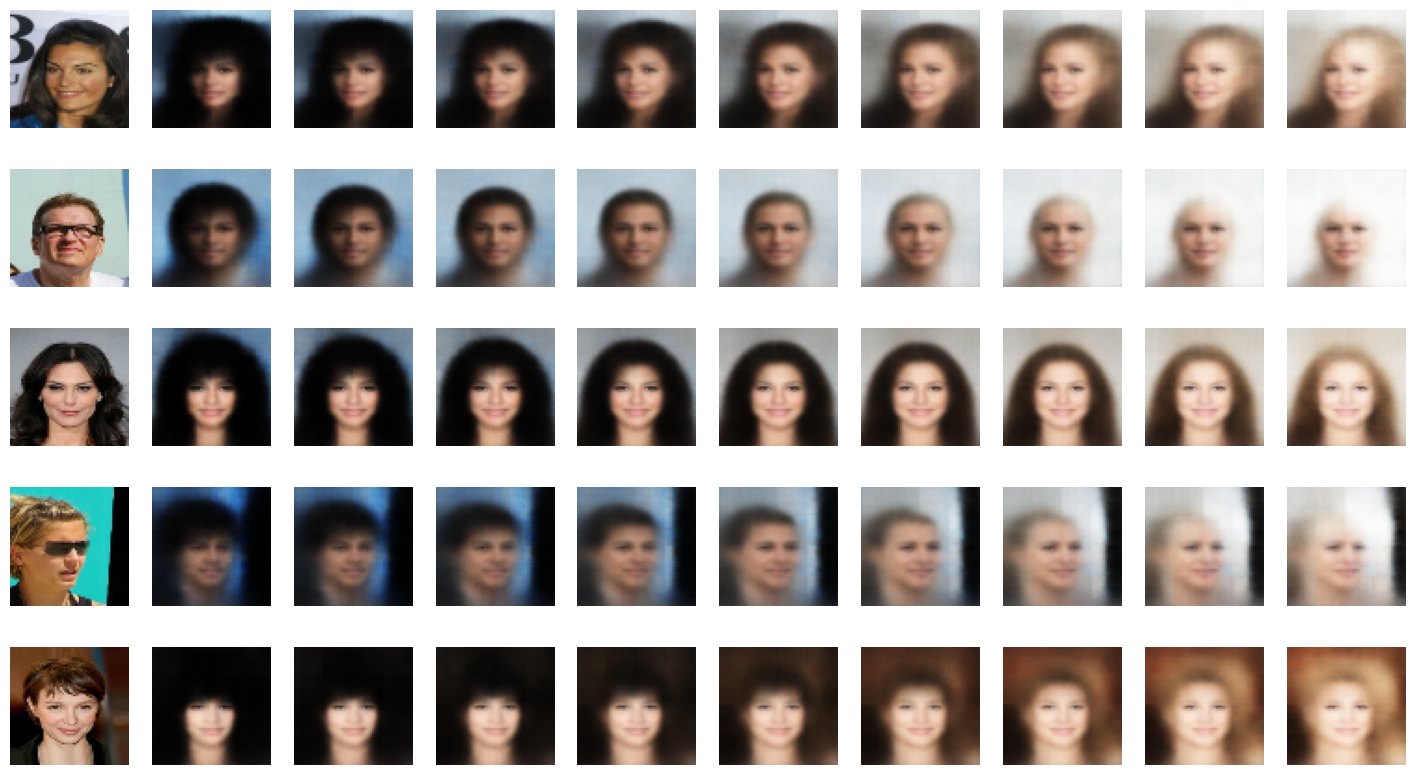

In [ ]:
# Add vector to images
add_vector_to_images(labelled, vae, attribute_vec)

# Morphing Between Faces

We can use a similar idea to morph between two faces.

Imagine two points in the
latent space, A and B, that represent two images. If you started at point A and walked
toward point B in a straight line, decoding each point on the line as you went, you
would see a gradual transition from the starting face to the end face.


Mathematically, we are traversing a straight line, which can be described by the following equation:


z_new = z_A * (1- alpha) + z_B * alpha


Here, alpha is a number between 0 and 1 that determines how far along the line we
are, away from point A.

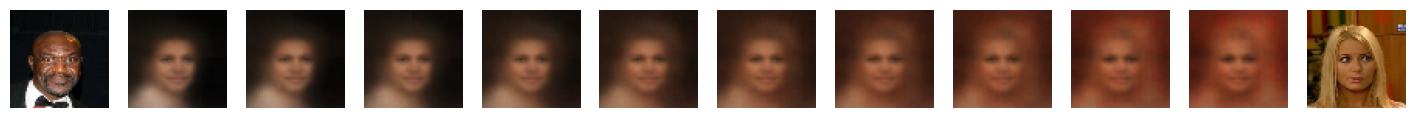

In [ ]:
morph_faces(labelled, vae)

It is remarkable that even though we are moving the point a significantly large dis‐
tance in the latent space, the core image remains approximately the same, except for
the one feature that we want to manipulate. This demonstrates the power of varia‐
tional autoencoders for capturing and adjusting high-level features in images.


It is worth noting the smoothness of the transition—even where there are multiple
features to change simultaneously (e.g., removal of glasses, hair color, gender), the
VAE manages to achieve this fluidly, showing that the latent space of the VAE is truly
a continuous space that can be traversed and explored to generate a multitude of dif‐
ferent human faces.